<a href="https://colab.research.google.com/github/shinji-kataoka/practice_iris/blob/main/%E7%B7%B4%E7%BF%92%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classの定義

In [ ]:
# クラスに落とし込む
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class AnalyzeIris:
    def __init__(self):
        self.iris_data = load_iris()
        self.df = pd.DataFrame(
            data=self.iris_data.data,
            columns=self.iris_data.feature_names
        )
        self.df['label'] = self.iris_data.target
        self.x = self.df.drop('label', axis=1)
        self.y = self.df['label']
        self.feature_names = self.x.columns
        self.models = [
            LogisticRegression(max_iter=1000),
            LinearSVC(max_iter=5000, dual = False),
            DecisionTreeClassifier(),
            KNeighborsClassifier(n_neighbors=4),
            LinearRegression(),
            RandomForestClassifier(),
            GradientBoostingClassifier(),
            MLPClassifier(max_iter=1000)]
        self.plot_models = [
            DecisionTreeClassifier(),
            RandomForestClassifier(),
            GradientBoostingClassifier()
        ]
        self.kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        self.scaler = [
            MinMaxScaler(),
            StandardScaler(),
            RobustScaler(),
            Normalizer()
            ]
        self.label_names = self.iris_data.target_names

    # データフレームを呼び出す関数
    def Get(self):
        return self.df

    # 散布図を描くための関数
    def PairPlot(self, cmap='brg'):
        return pd.plotting.scatter_matrix(
            self.x,
            c=self.y,
            figsize=(15, 15),
            marker = 'o',
            hist_kwds={'bins': 20},
            s=60,
            alpha=.8,
            cmap = cmap)

    def AllSupervised(self, n_neighbors = 4):
        # データの読み込み
        X = self.x
        y = self.y
        # KFoldの設定
        kfold = self.kfold
        # モデルのインスタンス
        models = self.models
        # モデルの名前を取得
        self.models_index = [x.__class__.__name__ for x in models]
        # 全ての手法のスコアを保存するリスト
        self.train_scores_list = []
        self.test_scores_list = []
        for model in models:
            # 各手法の交差検証のスコアを保存するリスト
            train_scores = []
            test_scores = []
            for fold, (train_index, test_index) in enumerate(kfold.split(X)):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                # モデルの訓練
                model.fit(X_train, y_train)
                # 訓練スコアとテストスコアの計算
                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)
                # 結果をリストに追加
                train_scores.append(train_score)
                test_scores.append(test_score)
            # 結果をリストに保存
            self.train_scores_list.append(train_scores)
            self.test_scores_list.append(test_scores)
        for i in range(len(self.models_index)):
            print(f'==={self.models_index[i]}===')
            for j in range(5):
                print(f'test score: {self.test_scores_list[i][j]:.3f}     train score: {self.train_scores_list[i][j]:.3f}')

    def GetSupervised(self):
        self.df_scores = pd.DataFrame(self.test_scores_list, index=self.models_index)
        return self.df_scores.T

    def BestSupervised(self):
        self.df_scores = pd.DataFrame(self.test_scores_list, index=self.models_index)
        self.df_scores['mean'] = self.df_scores.mean(axis=1)
        return self.df_scores['mean'].idxmax(), self.df_scores['mean'].max()

    def PlotFeatureImportanceAll(self):
    # ツリーベースのモデルのみを対象
        self.plot_models = [model for model in self.models if hasattr(model, "feature_importances_")]
        for model in self.plot_models:
            self.importances = model.feature_importances_
            self.indices = range(len(self.importances))
            plt.barh(self.indices, self.importances, align='center')
            plt.yticks(self.indices, self.df.columns[:-1])
            plt.xlabel(f'Feature Importance: {model.__class__.__name__}')
            plt.show()

    def VisualizeDecisionTree(self, figure_size=(16, 12), font_size=12):
        # 訓練済みの DecisionTreeClassifier を取得
        tree_model = next(model for model in self.models if isinstance(model, DecisionTreeClassifier))
        plt.figure(figsize=figure_size)
        # 決定木の可視化
        plot_tree(
            tree_model,
            feature_names=list(self.x.columns),
            class_names=list(self.iris_data.target_names),
            filled=True,
            impurity=False
            )
        plt.show()

    def PlotScaledData(self):
        kfold = self.kfold
        X = self.x
        y = self.y
        for fold, (train_index, test_index) in enumerate(kfold.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            train_score = []
            test_score = []
            X_train_scaled_list = [X_train.copy()]
            X_test_scaled_list = [X_test.copy()]
            # スケーリング方法の格納
            scaler = self.scaler
            # 用いるモデルの定義
            svm = LinearSVC(max_iter=5000, dual = False)
            svm.fit(X_train, y_train)
            train_score.append(svm.score(X_train, y_train))
            test_score.append(svm.score(X_test, y_test))
            for i in scaler:
                # 訓練データでスケーリング
                i.fit(X_train)
                X_train_scaled = i.transform(X_train)
                X_test_scaled = i.transform(X_test)
                # スケーリングしたデータをリストに追加
                X_train_scaled_list.append(pd.DataFrame(X_train_scaled, columns = X_train.columns, index = X_train.index))
                X_test_scaled_list.append(pd.DataFrame(X_test_scaled, columns = X_test.columns, index = X_test.index))
                # モデルのフィット
                svm.fit(X_train_scaled, y_train)
                train_score.append(svm.score(X_train_scaled, y_train))
                test_score.append(svm.score(X_test_scaled, y_test))

            for n in range(len(X_train.columns)):
                # スコアの出力
                print(f'Original     : test score: {test_score[0]:.3f}   train score: {train_score[0]:.3f}')
                for k in range(len(scaler)):
                    print(f'{scaler[k].__class__.__name__}   : test score: {test_score[k+1]:.3f}     train score: {train_score[k+1]:.3f}')
                # グラフの出力
                fig, axes = plt.subplots(1, 5, figsize=(15, 5))
                x_label = X_train.columns[n]
                y_label = X_train.columns[(n + 1) % len(X_train.columns)]
                axes[0].scatter(X_train_scaled_list[0].iloc[:, 0], X_train_scaled_list[0].iloc[:, 1], label='Train set')
                axes[0].scatter(X_test_scaled_list[0].iloc[:, 0], X_test_scaled_list[0].iloc[:, 1], label = 'Test set', marker = '^')
                axes[0].legend(loc = 'upper left')
                axes[0].set_title('Original Data')
                axes[0].set_xlabel(x_label)
                axes[0].set_ylabel(y_label)
                for i in scaler:
                    axes[scaler.index(i) + 1].scatter(X_train_scaled_list[scaler.index(i) + 1].iloc[:, 0], X_train_scaled_list[scaler.index(i) + 1].iloc[:, 1], label='Train set')
                    axes[scaler.index(i) + 1].scatter(X_test_scaled_list[scaler.index(i) + 1].iloc[:, 0], X_test_scaled_list[scaler.index(i) + 1].iloc[:, 1], label = 'Test set', marker = '^')
                    axes[scaler.index(i) + 1].set_title(f'{i.__class__.__name__}')
                    axes[scaler.index(i) + 1].set_xlabel(x_label)
                    axes[scaler.index(i) + 1].set_ylabel(y_label)
                plt.tight_layout()
                plt.show()
                print('=========================================================================')

    def PlotFeatureHistgram(self):
        X = self.x
        y = self.y
        df = self.df
        feature_names = X.columns
        setosa = df[y == 0]
        versicolor = df[y == 1]
        virginica = df[y == 2]
        fig, axes = plt.subplots(4, 1, figsize=(10, 20))
        for i in range(len(feature_names)):
            _, bins = np.histogram(X.iloc[:, i], bins=50)
            axes[i].hist(setosa.iloc[:, i], bins=bins, alpha=0.5, label='setosa')
            axes[i].hist(versicolor.iloc[:, i], bins=bins, alpha=0.5, label='versicolor')
            axes[i].hist(virginica.iloc[:, i], bins=bins, alpha=0.5, label='virginica')
            axes[i].set_xlabel(feature_names[i])
            axes[i].set_ylabel('Frequency')
            axes[i].legend()
        plt.show()

    def PlotPCA(self, n_components = 2):
        X = self.x
        y = self.y
        label_names = self.label_names
        # PCAのインスタンスを作成
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        df_X_scaled = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        pca = PCA(n_components=n_components)
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)
        df_X_pca = pd.DataFrame(X_pca)
        # 散布図の描画
        colors = ['blue', 'orange', 'green']
        markers = ['o', '^', 'v']
        plt.figure(figsize=(8, 8))
        for color, marker, i, target_name in zip(colors, markers, [0, 1, 2], label_names):
            plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=0.8, lw=2, marker=marker, label=target_name)
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(label_names, loc = 'best')
        plt.gca().set_aspect('equal')
        # ヒートマップの描画
        plt.figure(figsize=(8, 4))
        plt.matshow(pca.components_, cmap='viridis')
        plt.yticks([0, 1], ['First component', 'Second component'])
        plt.colorbar()
        plt.xticks(range(len(X.columns)), X.columns, rotation=60, ha = 'left')
        plt.xlabel('Feature')
        plt.ylabel('Principal component')
        return df_X_scaled, df_X_pca, pca

    def PlotNMF(self, n_components = 2):
        X, y = self.x, self.y
        label_names = self.label_names
        # PCAのインスタンスを作成
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        df_X_scaled = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
        nmf = NMF(n_components=n_components, random_state=0, max_iter=1000, init = 'nndsvd')
        nmf.fit(X)
        X_nmf = nmf.transform(X)
        df_X_nmf = pd.DataFrame(X_nmf)
        # グラフの描画
        colors = ['blue', 'orange', 'green']
        markers = ['o', '^', 'v']
        plt.figure(figsize=(8, 8))
        for color, marker, i, target_name in zip(colors, markers, [0, 1, 2], label_names):
            plt.scatter(X_nmf[y == i, 0], X_nmf[y == i, 1], color=color, alpha=0.8, lw=2, marker=marker, label=target_name)
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(label_names, loc = 'best')
        # plt.gca().set_aspect('equal')

        plt.figure(figsize=(8, 4))
        plt.matshow(nmf.components_, cmap='viridis')
        plt.yticks([0, 1], ['First component', 'Second component'])
        plt.colorbar()
        plt.xticks(range(len(X.columns)), X.columns, rotation=60, ha = 'left')
        plt.xlabel('Feature')
        plt.ylabel('Principal component')
        return df_X_scaled, df_X_nmf, nmf

    def PlotTSNE(self, n_components = 2):
        X, y = self.x, self.y
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        plt.figure(figsize=(8, 8))
        plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max() + 1)
        plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max() + 1)
        for i in range(len(X)):
            plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y.iloc[i]), color='black', fontsize=9)
        plt.xlabel('t-SNE feature 1')
        plt.show()

    def PlotKMeans(self):
        X, y = self.x, self.y
        # KMeansクラスタリングの適用
        kmeans = KMeans(n_clusters=3, random_state=0, n_init = 10)
        kmeans.fit(X)
        assignments = kmeans.labels_  # クラスタリング結果のラベル
        print(f'KMeans法で予測したラベル: {kmeans.labels_}')
        # クラスタリング結果をプロット (mglearn.discrete_scatter の再現)
        plt.figure(figsize=(8, 6))
        colors = ['blue', 'orange', 'green']
        markers = ['o', '*', 'D']
        for i, (color, marker) in enumerate(zip(colors, markers)):
            plt.scatter(
                X.iloc[assignments == i, 2],  # クラスタ i の x 座標
                X.iloc[assignments == i, 3],  # クラスタ i の y 座標
                color=color, marker=marker, s=100, edgecolor='k'
            )
        plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3],
                    color='white', edgecolors='k', marker='^', s=200, linewidths=2)
        plt.show()
        print(f'実際のラベル: {y.values}')
        # 実際のラベルをプロット
        plt.figure(figsize=(8, 6))
        for i, (color, marker) in enumerate(zip(colors, markers)):
            plt.scatter(X.loc[y == i, X.columns[2]], X.loc[y == i, X.columns[3]], color=color, marker=marker, s=100, edgecolor='k')
        plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3],
                    color='white', edgecolors='k', marker='^', s=200, linewidths=2)
        plt.show()

    def PlotDendrogram(self, truncate = False):
        X = self.x
        linkage_array = ward(X)
        plt.figure(figsize = (10, 5))
        a, b = 10, 5.5
        ax = plt.gca()
        if truncate:
            dendrogram(linkage_array, truncate_mode = 'lastp', p = 10)
        else:
            dendrogram(linkage_array)
            bounds = ax.get_xbound()
            ax.plot(bounds, [a, a], '--', c = 'k')
            ax.plot(bounds, [b, b], '--', c = 'k')
            ax.text(bounds[1], a, '3 clusters', va = 'center', ha = 'left', size = 15)
            ax.text(bounds[1], b, '4 clusters', va = 'center', ha = 'left', size = 15)
        plt.xlabel('sample index')
        plt.ylabel('Cluster distance')
        plt.show()

    def PlotDBSCAN(self, scaling = False, eps=1, min_samples=5):
        X = self.x
        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
            X = pd.DataFrame(X, columns=self.x.columns, index=self.x.index)
        else:
            X = X.copy()
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X)
        print(f'Cluster membership: {clusters}')
        plt.figure(figsize=(8, 6))
        plt.scatter(X.iloc[:, 2], X.iloc[:, 3], c=clusters, cmap='brg', marker='o', s=50)
        plt.xlabel('Feature 2')
        plt.ylabel('Feature 3')
        plt.show()




# **練習問題1**

In [ ]:
# in[2]
iris = AnalyzeIris()
iris.Get()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


array([[<Axes: xlabel='sepal length (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='sepal length (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='sepal width (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='petal length (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='petal width (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='petal width (cm)'>,
  

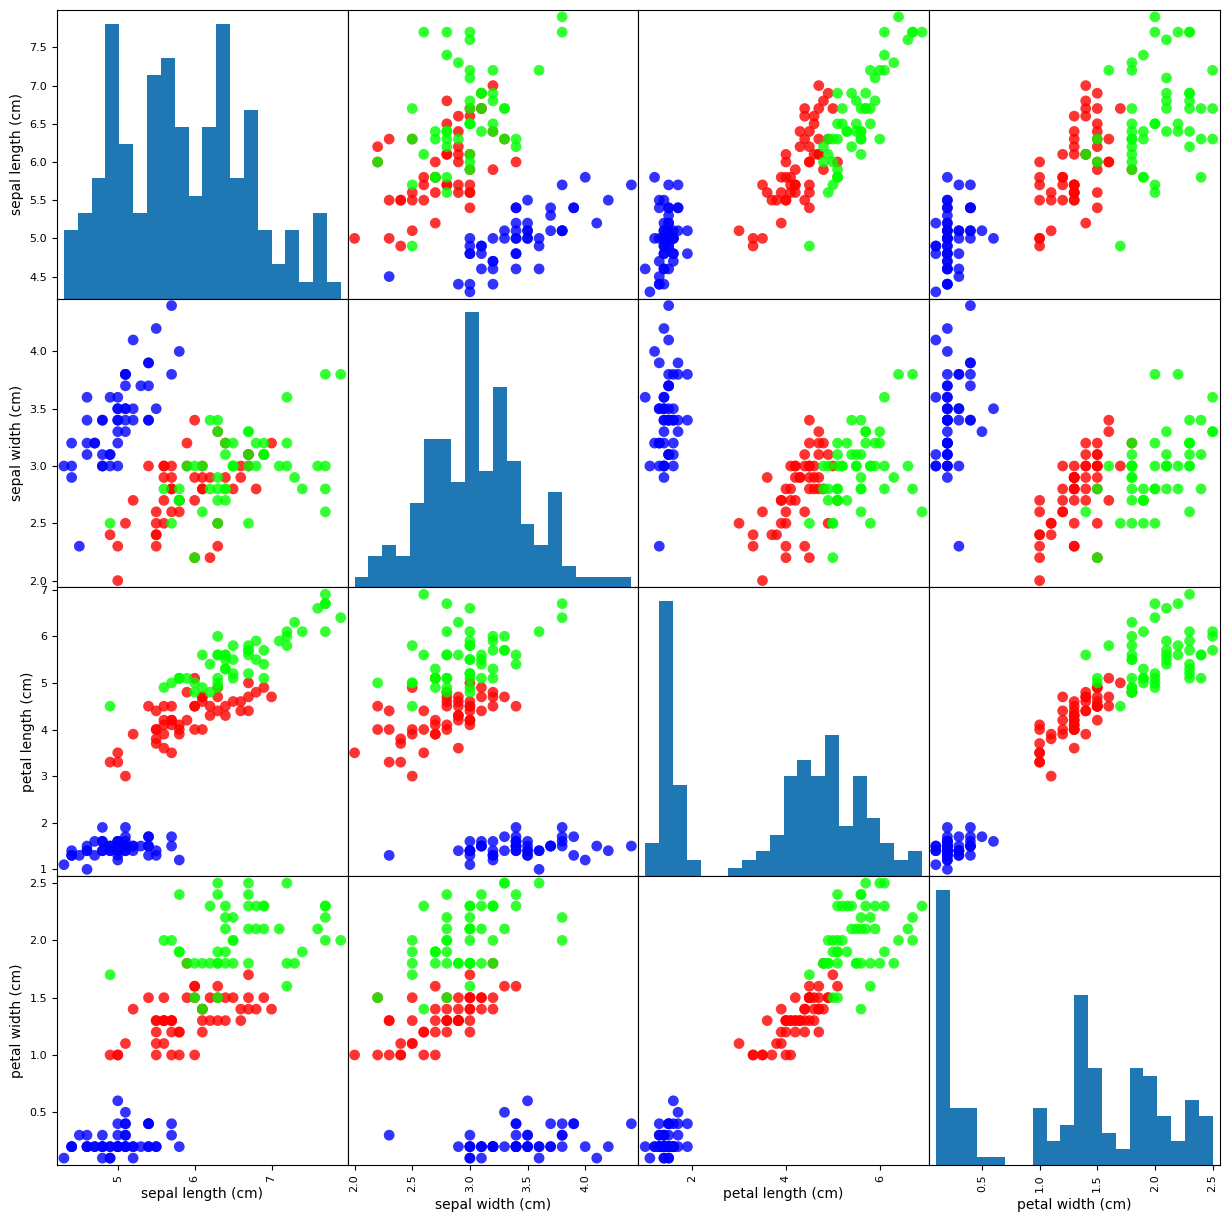

In [ ]:
# In[3]
iris.PairPlot()

array([[<Axes: xlabel='sepal length (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='sepal length (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='sepal length (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='sepal width (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='sepal width (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='petal length (cm)', ylabel='petal length (cm)'>,
        <Axes: xlabel='petal width (cm)', ylabel='petal length (cm)'>],
       [<Axes: xlabel='sepal length (cm)', ylabel='petal width (cm)'>,
        <Axes: xlabel='sepal width (cm)', ylabel='petal width (cm)'>,
  

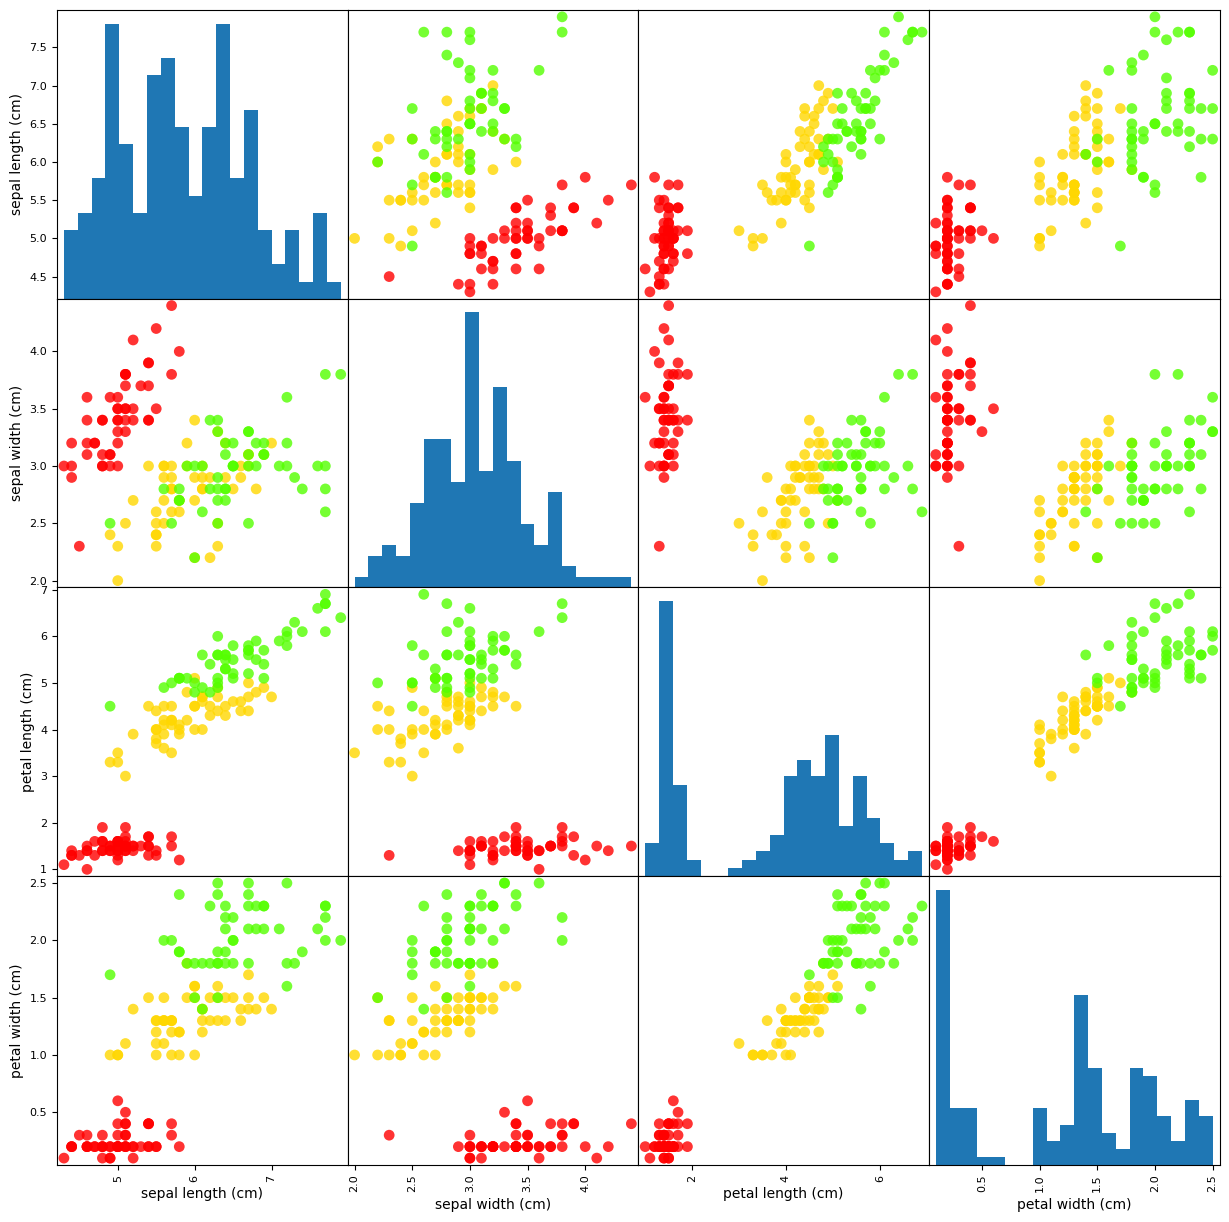

In [ ]:
# In[4]
iris.PairPlot(cmap = 'prism')

# **練習問題2**


In [ ]:
# In[6]
iris.AllSupervised(n_neighbors = 4)

===LogisticRegression===
test score: 1.000     train score: 0.967
test score: 0.833     train score: 0.975
test score: 1.000     train score: 0.967
test score: 1.000     train score: 0.975
test score: 0.933     train score: 0.983
===LinearSVC===
test score: 1.000     train score: 0.958
test score: 0.867     train score: 0.983
test score: 1.000     train score: 0.975
test score: 0.967     train score: 0.967
test score: 0.933     train score: 0.975
===DecisionTreeClassifier===
test score: 1.000     train score: 1.000
test score: 0.900     train score: 1.000
test score: 1.000     train score: 1.000
test score: 0.933     train score: 1.000
test score: 0.933     train score: 1.000
===KNeighborsClassifier===
test score: 1.000     train score: 0.950
test score: 0.867     train score: 0.992
test score: 1.000     train score: 0.958
test score: 1.000     train score: 0.958
test score: 0.933     train score: 0.975
===LinearRegression===
test score: 0.906     train score: 0.934
test score: 0.842  

In [ ]:
# In[7]
iris.GetSupervised()

,LogisticRegression,LinearSVC,DecisionTreeClassifier,KNeighborsClassifier,LinearRegression,RandomForestClassifier,GradientBoostingClassifier,MLPClassifier
0,1.000000,1.000000,1.000000,1.000000,0.905503,1.000000,1.000000,1.000000
1,0.833333,0.866667,0.900000,0.866667,0.841859,0.866667,0.900000,0.933333
2,1.000000,1.000000,1.000000,1.000000,0.945698,1.000000,1.000000,1.000000
3,1.000000,0.966667,0.933333,1.000000,0.962310,1.000000,0.966667,1.000000
4,0.933333,0.933333,0.933333,0.933333,0.933661,0.933333,0.933333,0.933333


In [ ]:
# In[8]
iris.GetSupervised().describe()

,LogisticRegression,LinearSVC,DecisionTreeClassifier,KNeighborsClassifier,LinearRegression,RandomForestClassifier,GradientBoostingClassifier,MLPClassifier
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.953333,0.953333,0.953333,0.960000,0.917806,0.960000,0.960000,0.973333
std,0.073030,0.055777,0.044721,0.059628,0.047247,0.059628,0.043461,0.036515
min,0.833333,0.866667,0.900000,0.866667,0.841859,0.866667,0.900000,0.933333
25%,0.933333,0.933333,0.933333,0.933333,0.905503,0.933333,0.933333,0.933333
50%,1.000000,0.966667,0.933333,1.000000,0.933661,1.000000,0.966667,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.945698,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.962310,1.000000,1.000000,1.000000


In [ ]:
# in[9]
best_method, best_score = iris.BestSupervised()
print("BestMethod is ", best_method, " : ", "{0:0.4f}".format(best_score))

BestMethod is  MLPClassifier  :  0.9733


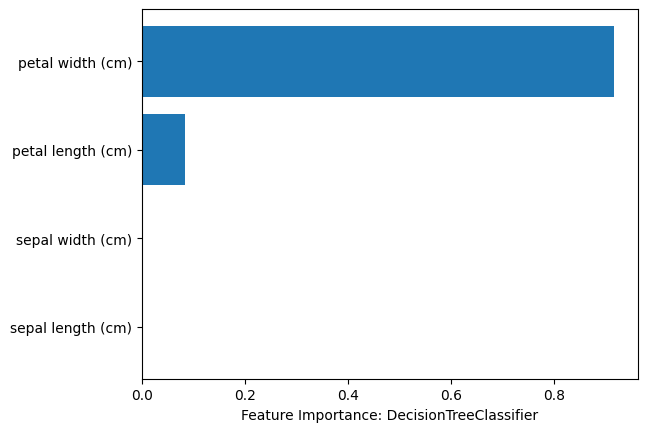

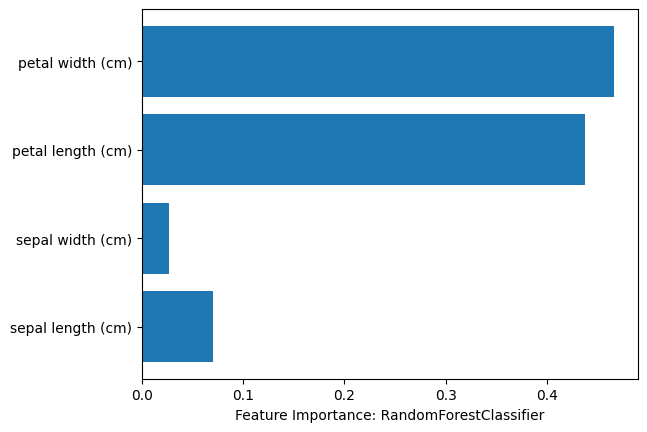

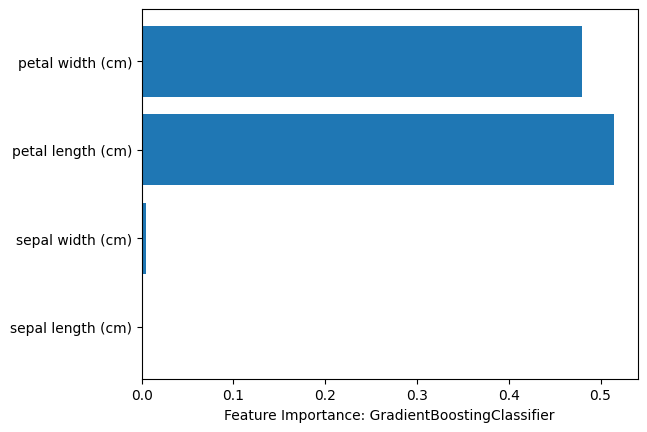

In [ ]:
# In[10]
iris.PlotFeatureImportanceAll()

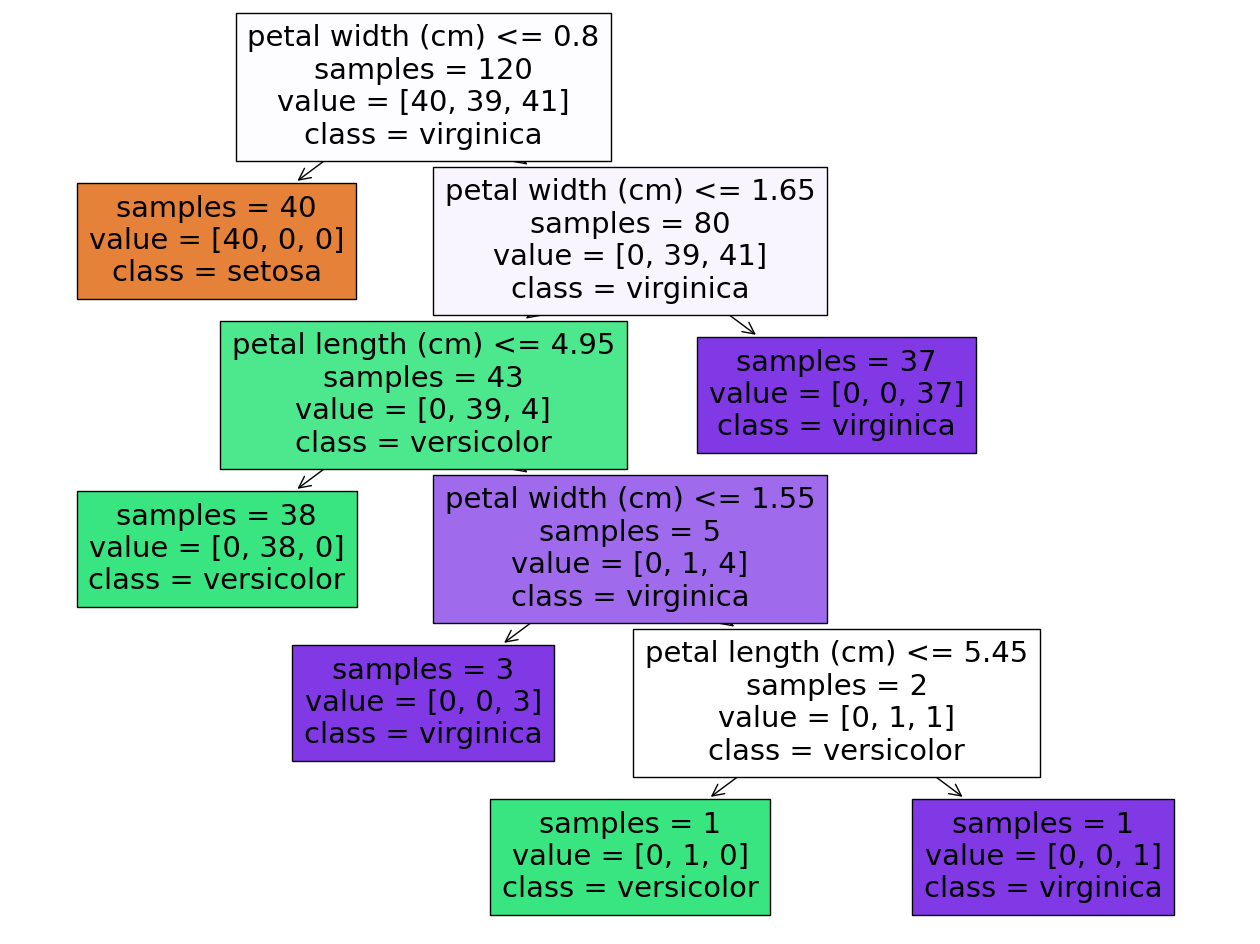

In [ ]:
# In[11]
graph = iris.VisualizeDecisionTree()
graph

# 練習問題3

Original     : test score: 1.000   train score: 0.958
MinMaxScaler   : test score: 0.900     train score: 0.925
StandardScaler   : test score: 0.967     train score: 0.942
RobustScaler   : test score: 0.967     train score: 0.925
Normalizer   : test score: 0.733     train score: 0.833


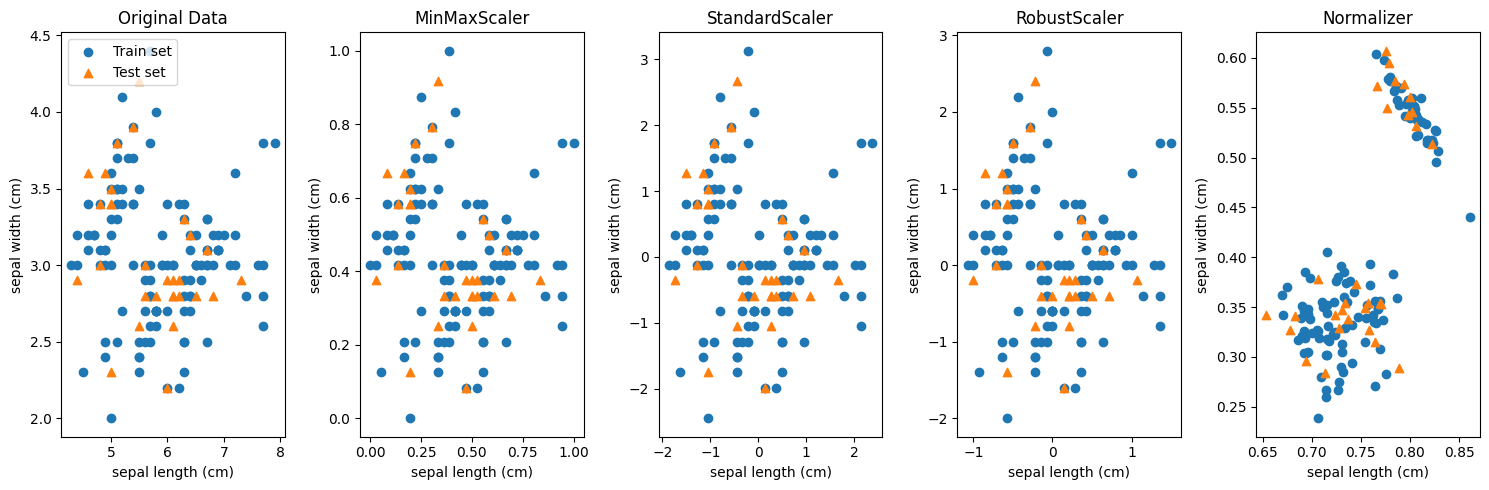

Original     : test score: 1.000   train score: 0.958
MinMaxScaler   : test score: 0.900     train score: 0.925
StandardScaler   : test score: 0.967     train score: 0.942
RobustScaler   : test score: 0.967     train score: 0.925
Normalizer   : test score: 0.733     train score: 0.833


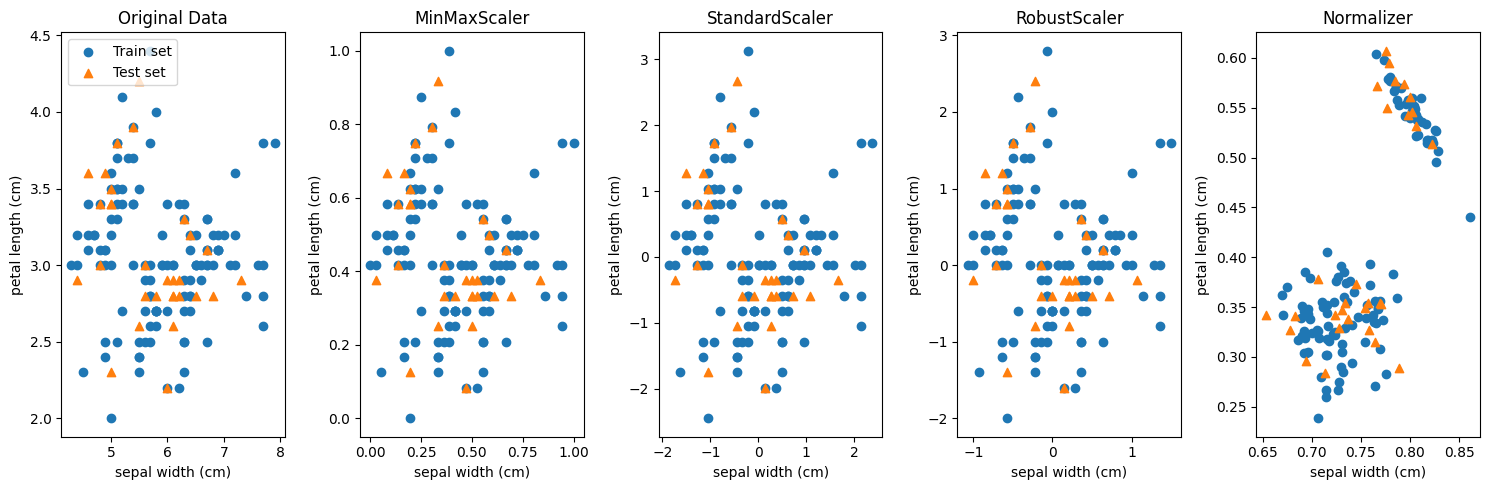

Original     : test score: 1.000   train score: 0.958
MinMaxScaler   : test score: 0.900     train score: 0.925
StandardScaler   : test score: 0.967     train score: 0.942
RobustScaler   : test score: 0.967     train score: 0.925
Normalizer   : test score: 0.733     train score: 0.833


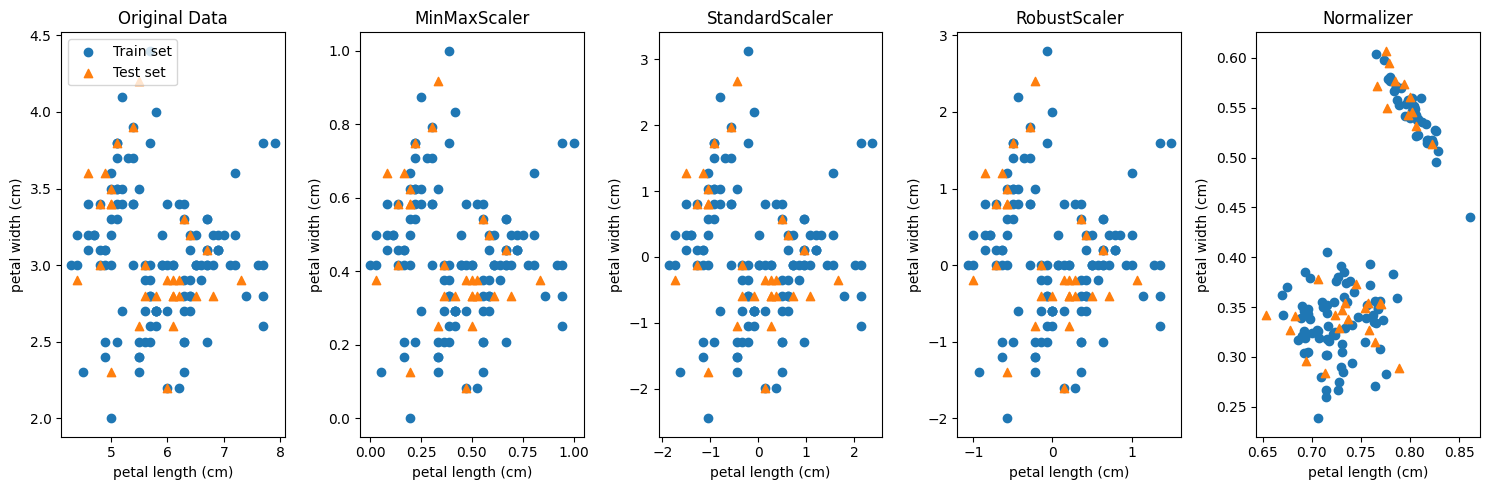

Original     : test score: 1.000   train score: 0.958
MinMaxScaler   : test score: 0.900     train score: 0.925
StandardScaler   : test score: 0.967     train score: 0.942
RobustScaler   : test score: 0.967     train score: 0.925
Normalizer   : test score: 0.733     train score: 0.833


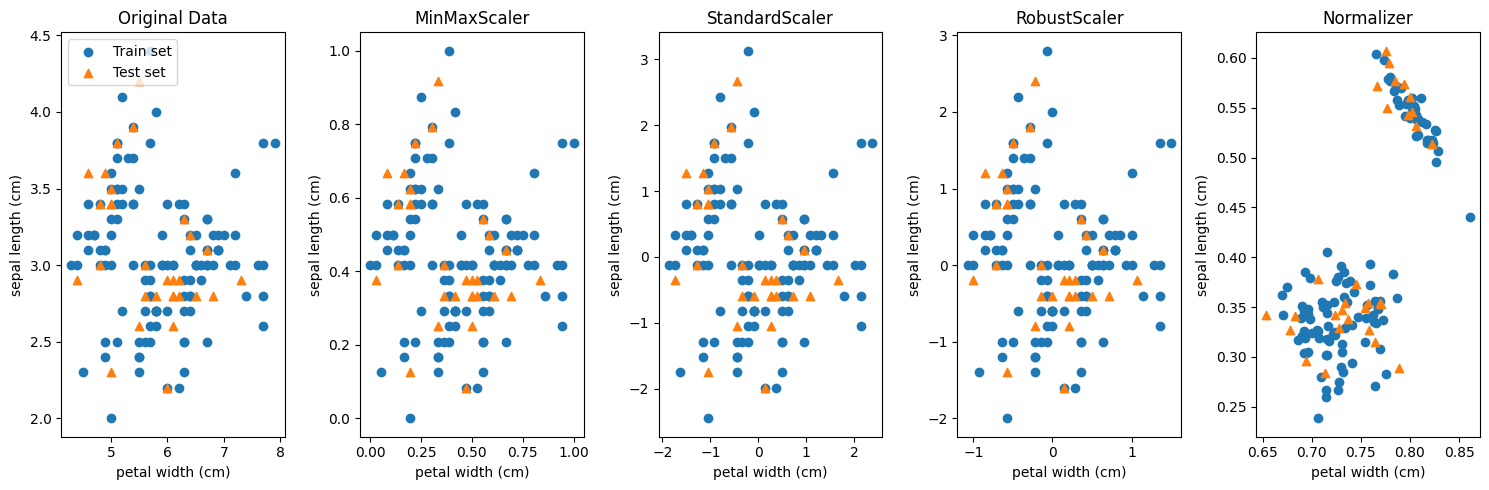

Original     : test score: 0.867   train score: 0.983
MinMaxScaler   : test score: 0.833     train score: 0.967
StandardScaler   : test score: 0.900     train score: 0.967
RobustScaler   : test score: 0.867     train score: 0.958
Normalizer   : test score: 0.867     train score: 0.967


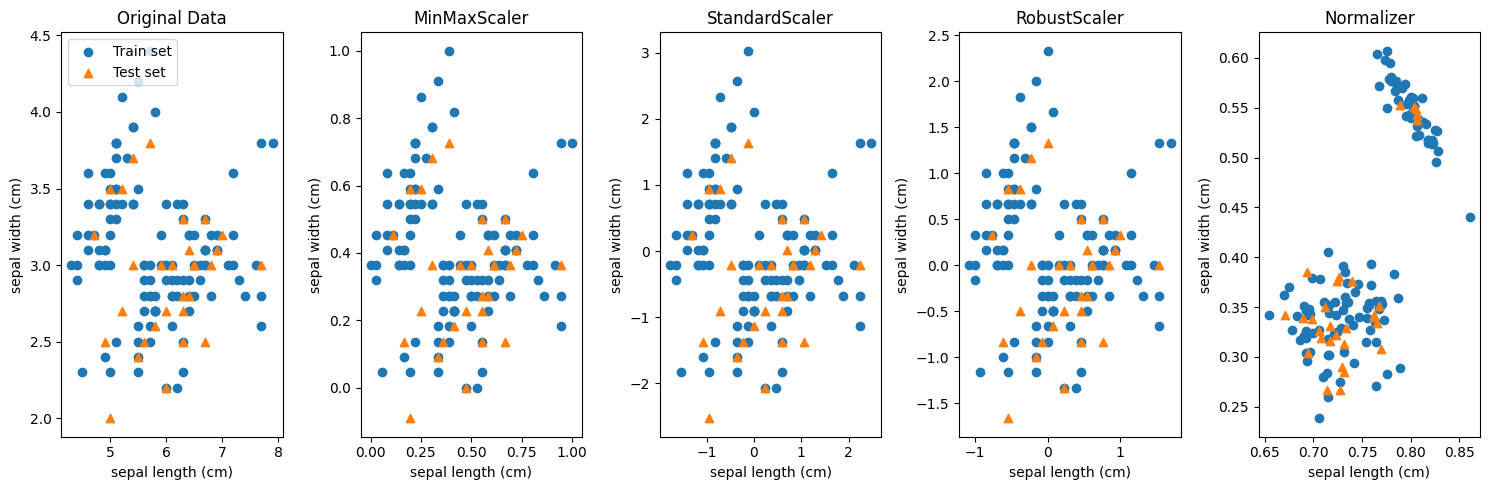

Original     : test score: 0.867   train score: 0.983
MinMaxScaler   : test score: 0.833     train score: 0.967
StandardScaler   : test score: 0.900     train score: 0.967
RobustScaler   : test score: 0.867     train score: 0.958
Normalizer   : test score: 0.867     train score: 0.967


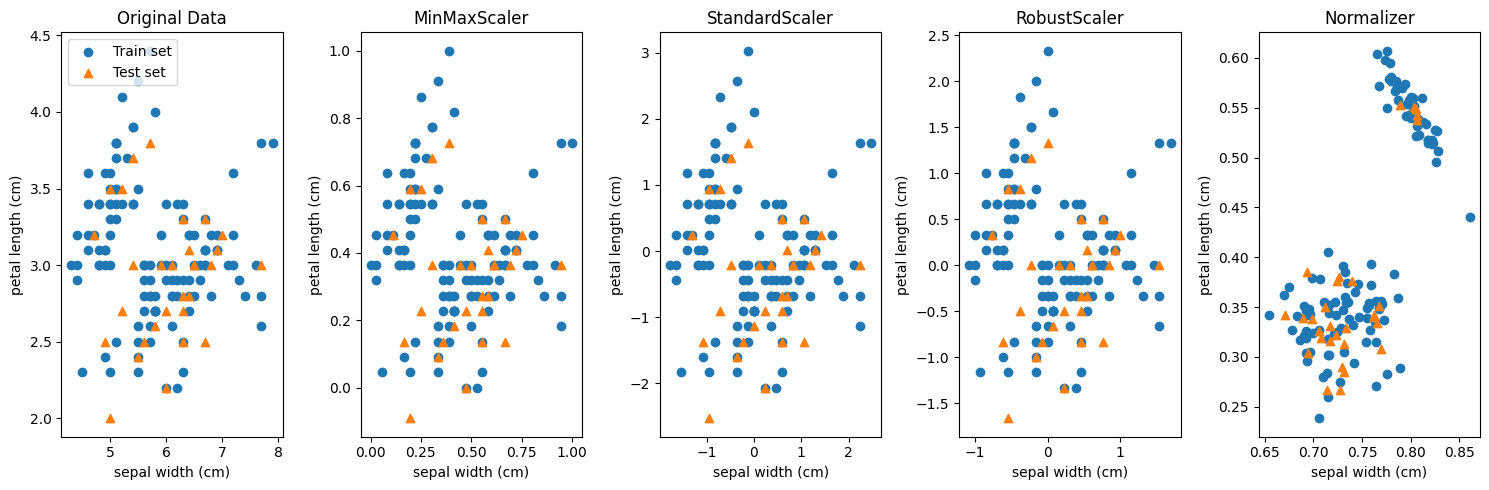

Original     : test score: 0.867   train score: 0.983
MinMaxScaler   : test score: 0.833     train score: 0.967
StandardScaler   : test score: 0.900     train score: 0.967
RobustScaler   : test score: 0.867     train score: 0.958
Normalizer   : test score: 0.867     train score: 0.967


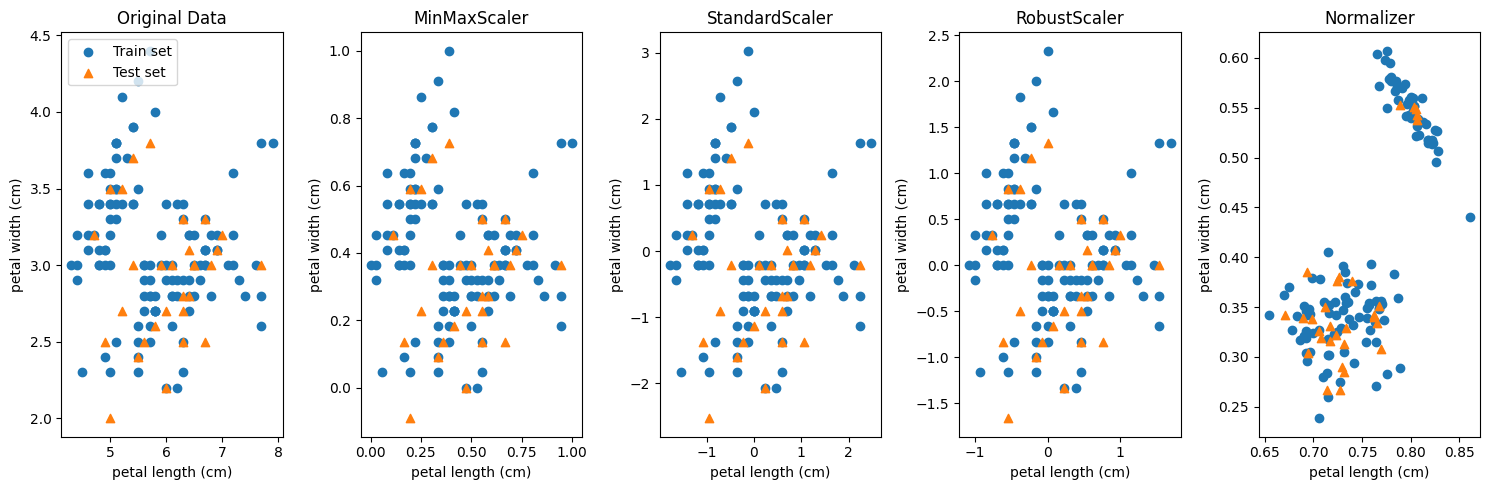

Original     : test score: 0.867   train score: 0.983
MinMaxScaler   : test score: 0.833     train score: 0.967
StandardScaler   : test score: 0.900     train score: 0.967
RobustScaler   : test score: 0.867     train score: 0.958
Normalizer   : test score: 0.867     train score: 0.967


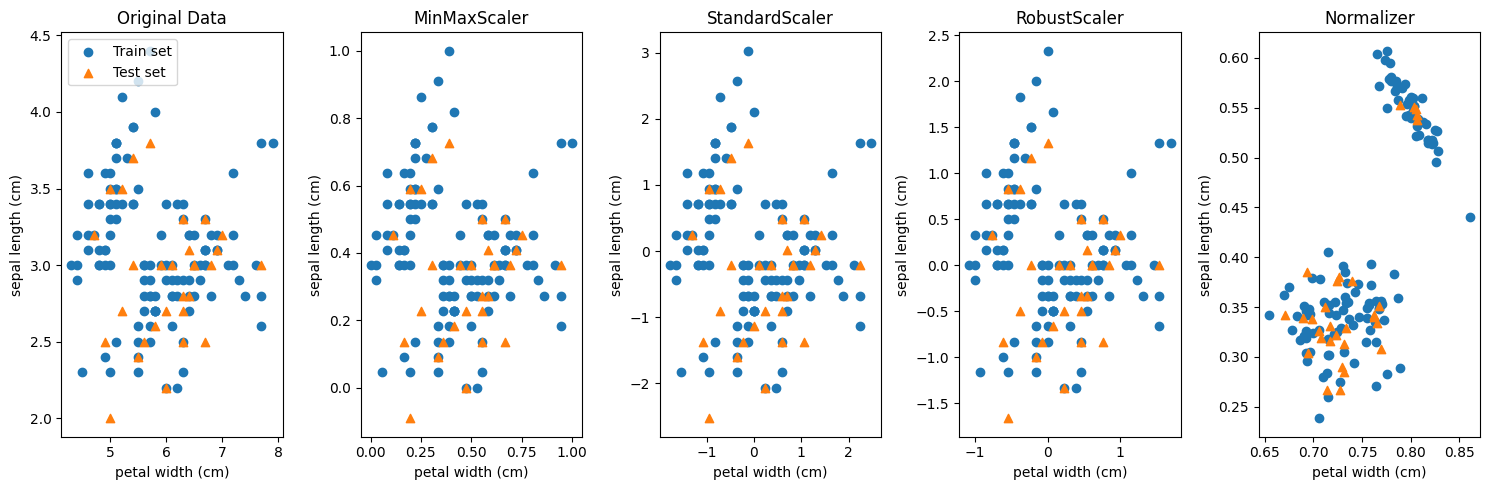

Original     : test score: 1.000   train score: 0.975
MinMaxScaler   : test score: 0.967     train score: 0.942
StandardScaler   : test score: 1.000     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.892


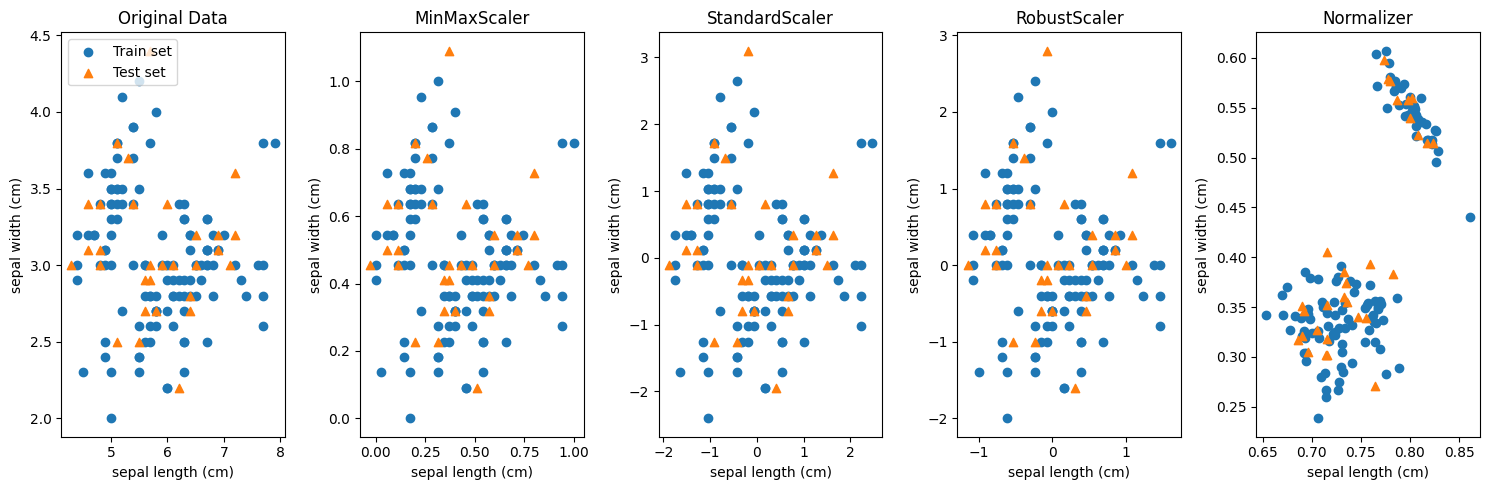

Original     : test score: 1.000   train score: 0.975
MinMaxScaler   : test score: 0.967     train score: 0.942
StandardScaler   : test score: 1.000     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.892


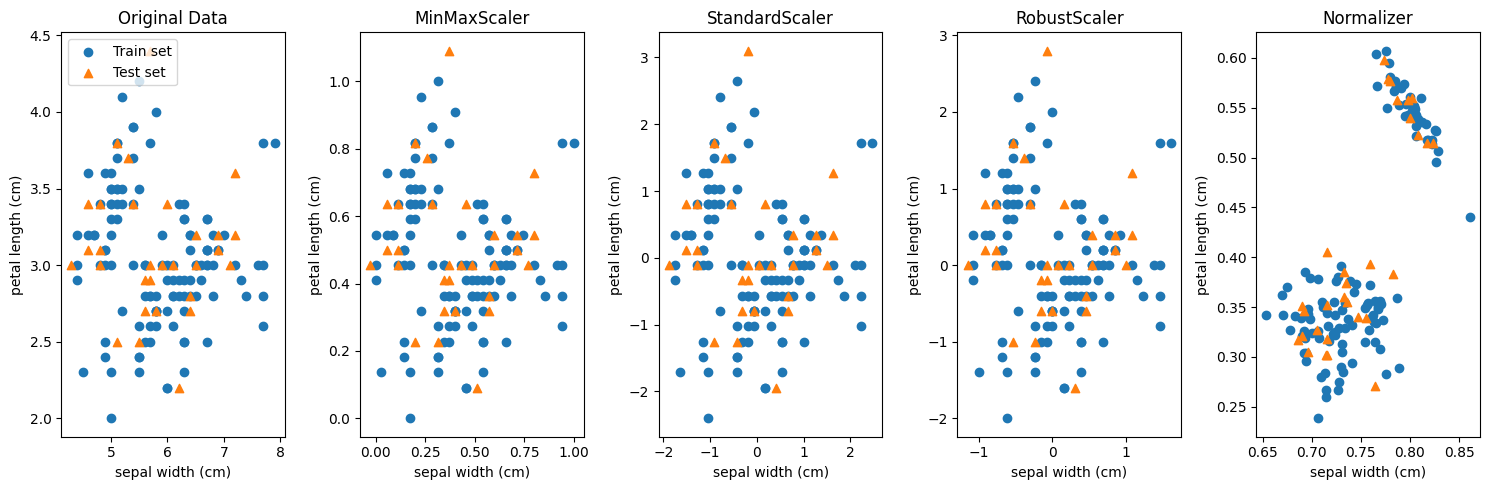

Original     : test score: 1.000   train score: 0.975
MinMaxScaler   : test score: 0.967     train score: 0.942
StandardScaler   : test score: 1.000     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.892


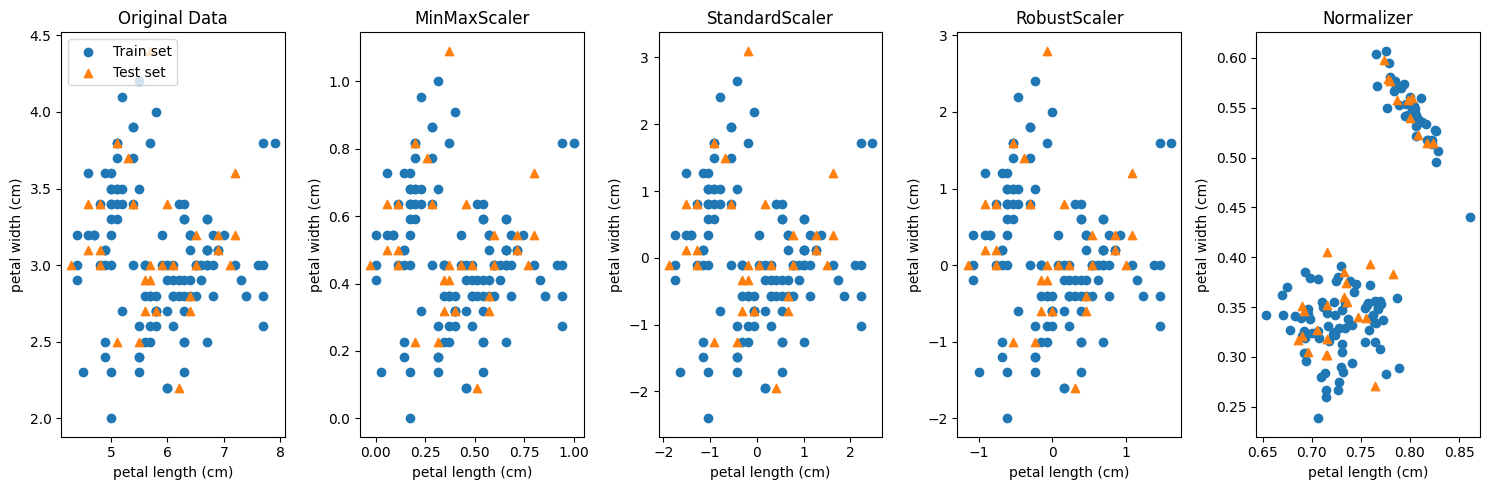

Original     : test score: 1.000   train score: 0.975
MinMaxScaler   : test score: 0.967     train score: 0.942
StandardScaler   : test score: 1.000     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.892


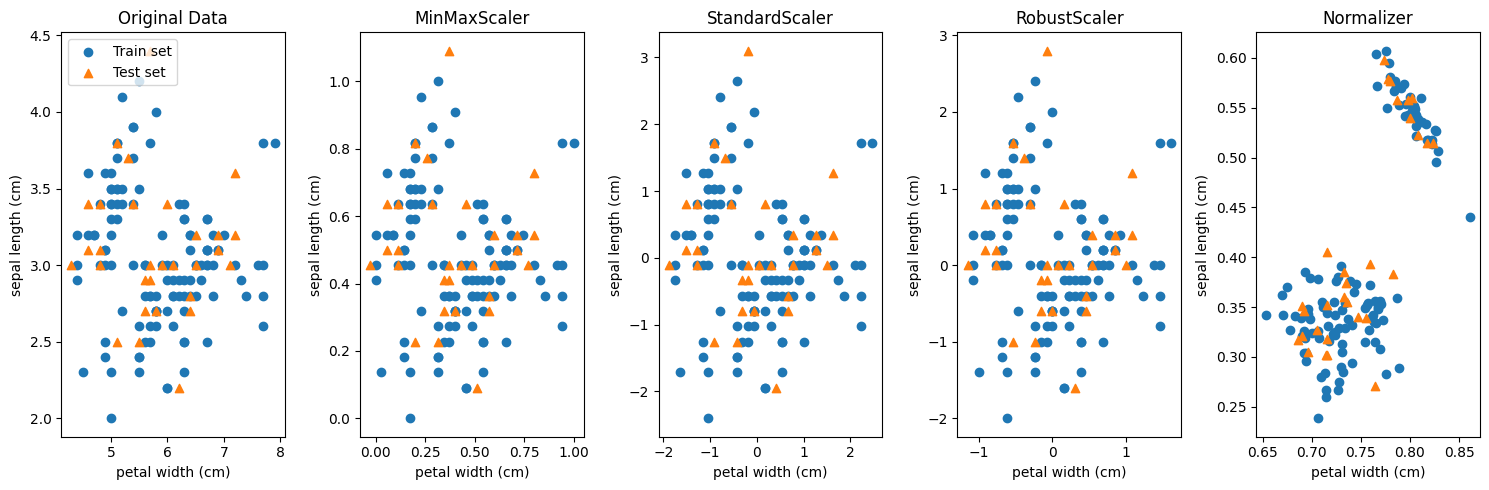

Original     : test score: 0.967   train score: 0.967
MinMaxScaler   : test score: 1.000     train score: 0.942
StandardScaler   : test score: 0.967     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.942


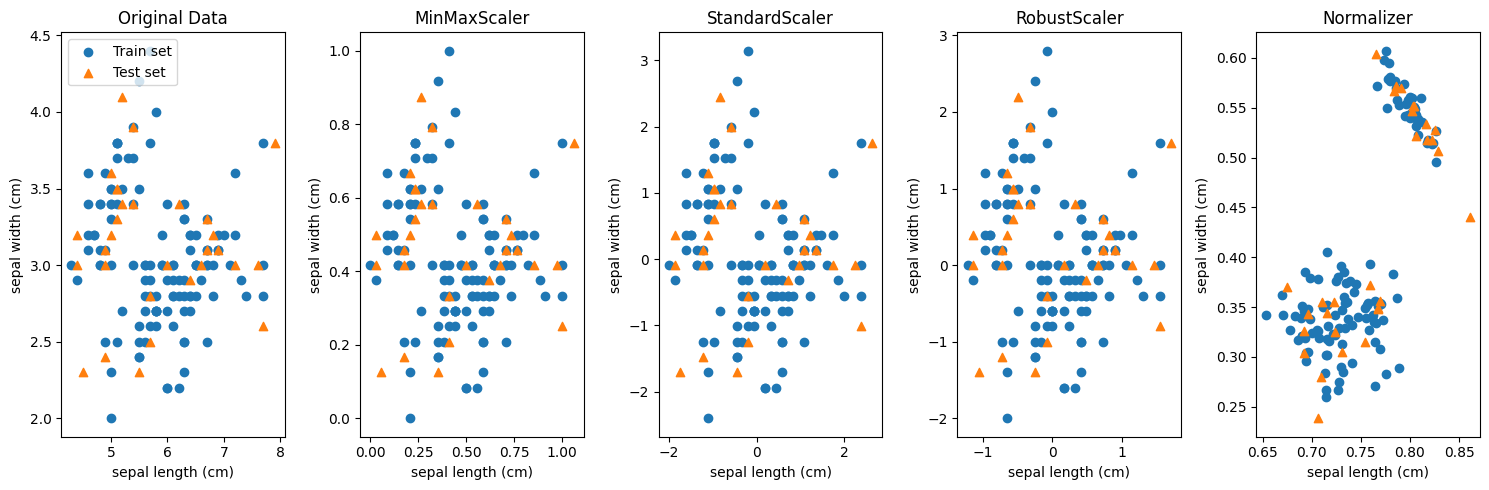

Original     : test score: 0.967   train score: 0.967
MinMaxScaler   : test score: 1.000     train score: 0.942
StandardScaler   : test score: 0.967     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.942


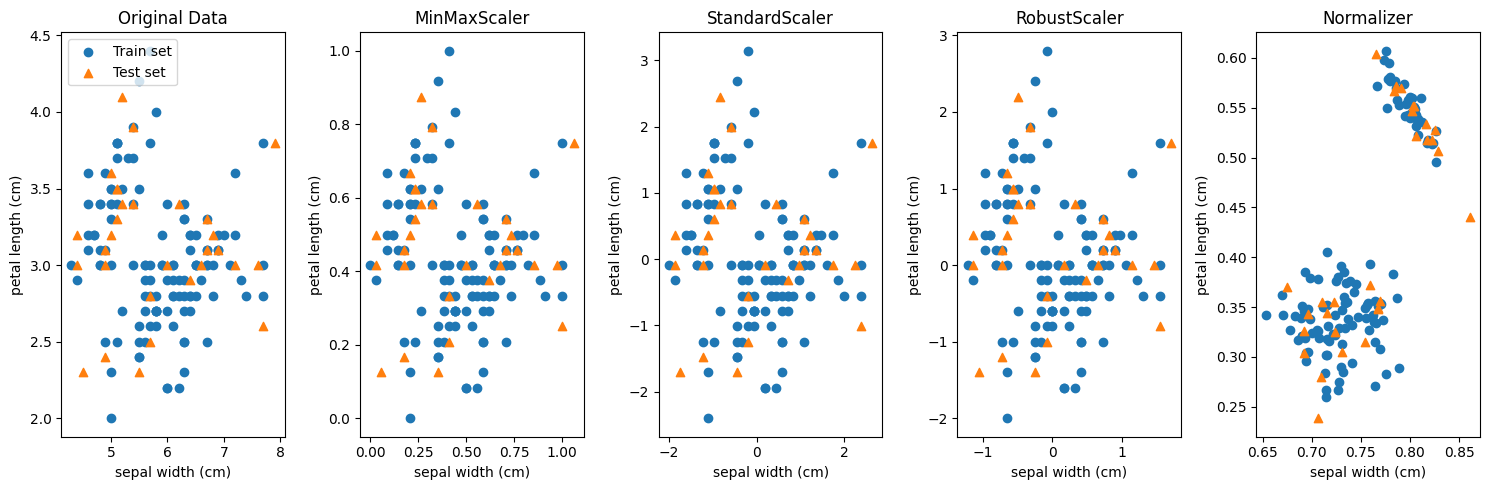

Original     : test score: 0.967   train score: 0.967
MinMaxScaler   : test score: 1.000     train score: 0.942
StandardScaler   : test score: 0.967     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.942


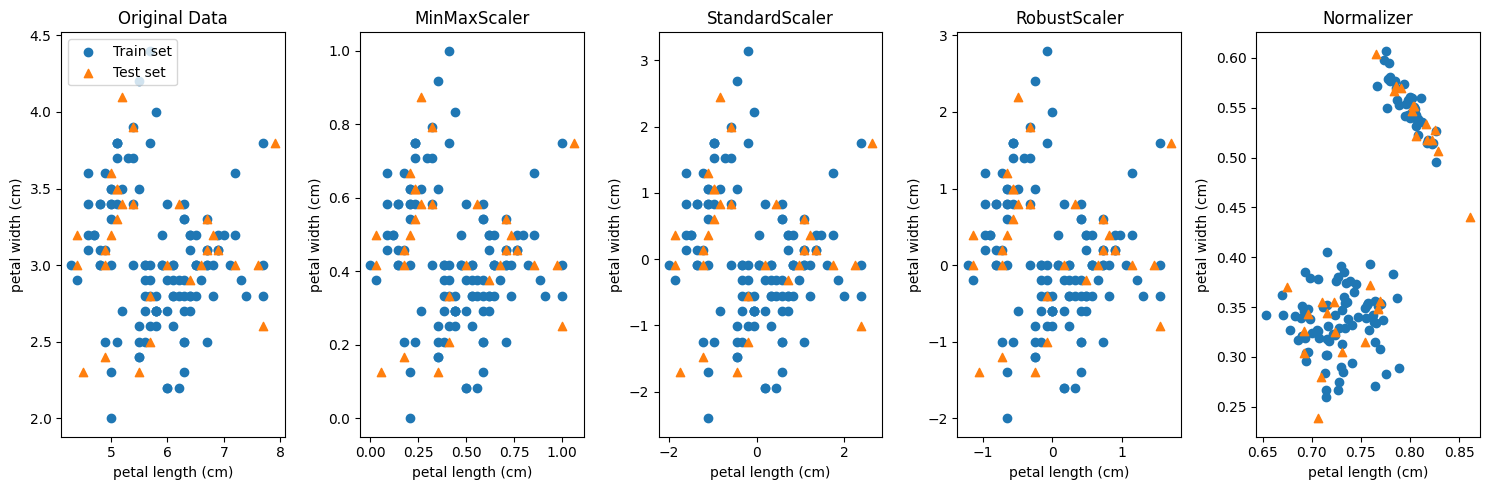

Original     : test score: 0.967   train score: 0.967
MinMaxScaler   : test score: 1.000     train score: 0.942
StandardScaler   : test score: 0.967     train score: 0.950
RobustScaler   : test score: 0.967     train score: 0.942
Normalizer   : test score: 0.967     train score: 0.942


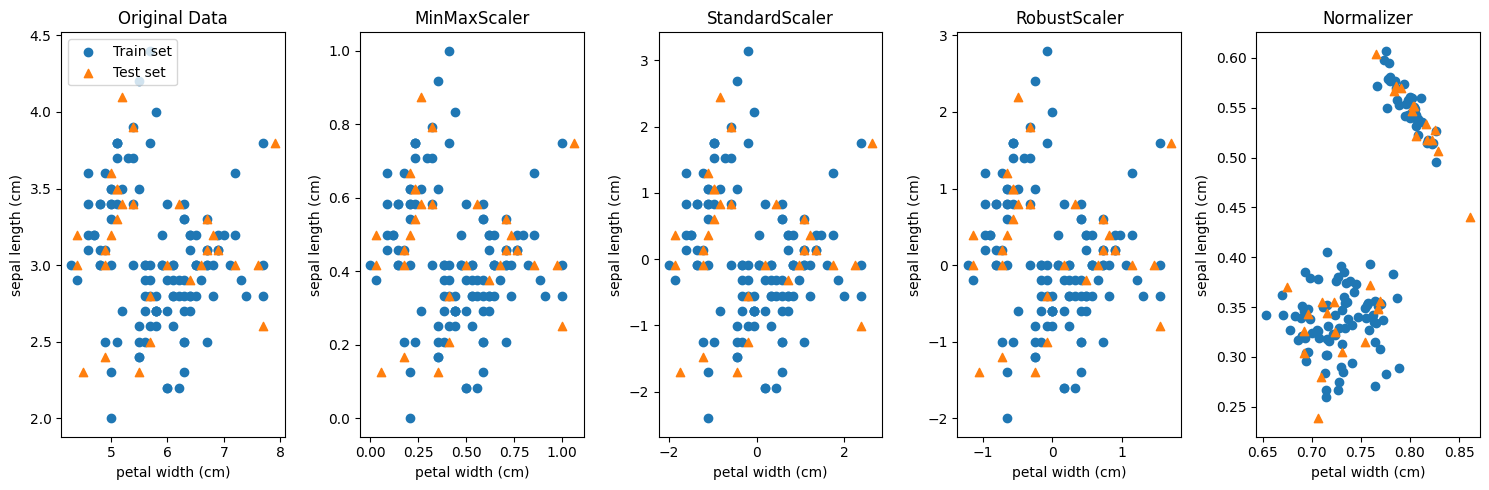

Original     : test score: 0.933   train score: 0.975
MinMaxScaler   : test score: 0.933     train score: 0.933
StandardScaler   : test score: 0.933     train score: 0.950
RobustScaler   : test score: 0.933     train score: 0.950
Normalizer   : test score: 0.867     train score: 0.858


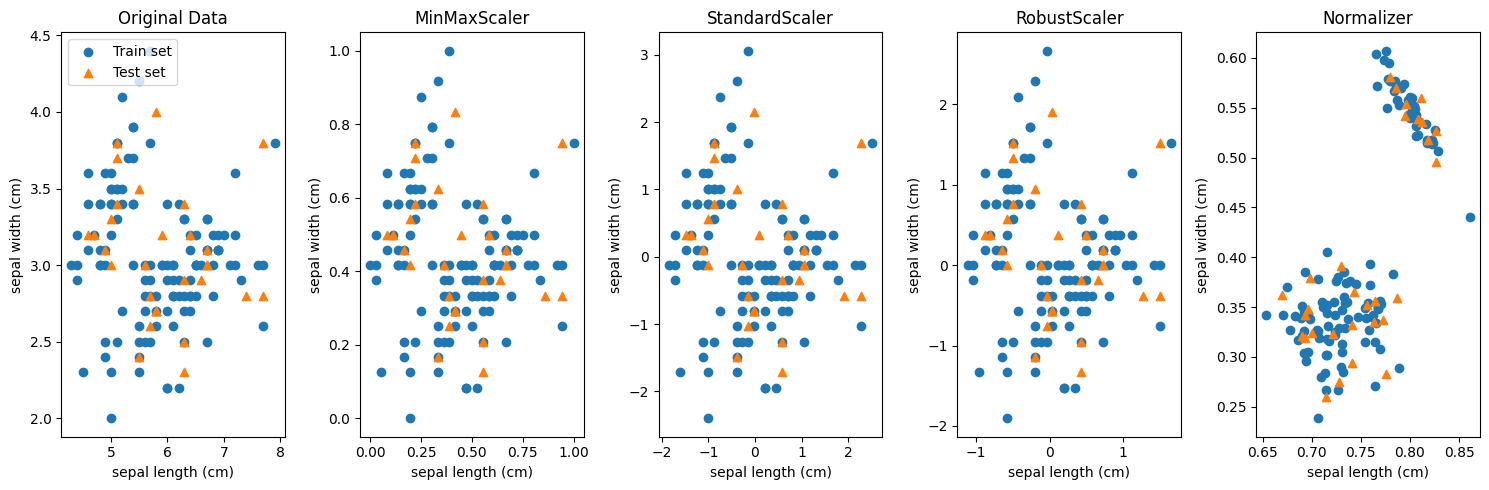

Original     : test score: 0.933   train score: 0.975
MinMaxScaler   : test score: 0.933     train score: 0.933
StandardScaler   : test score: 0.933     train score: 0.950
RobustScaler   : test score: 0.933     train score: 0.950
Normalizer   : test score: 0.867     train score: 0.858


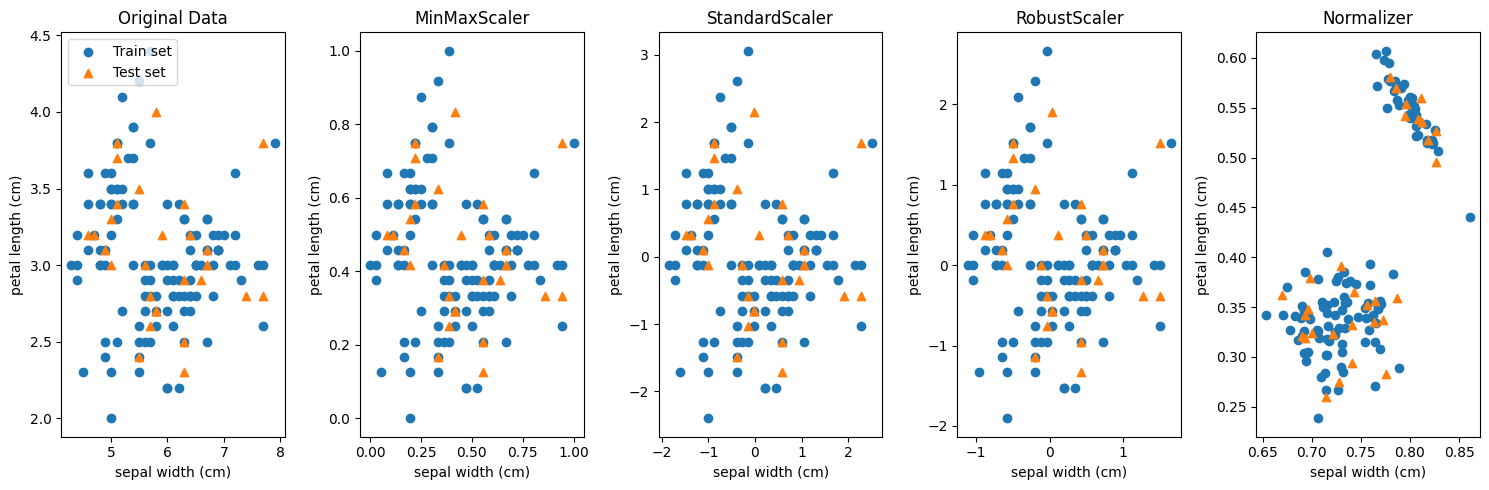

Original     : test score: 0.933   train score: 0.975
MinMaxScaler   : test score: 0.933     train score: 0.933
StandardScaler   : test score: 0.933     train score: 0.950
RobustScaler   : test score: 0.933     train score: 0.950
Normalizer   : test score: 0.867     train score: 0.858


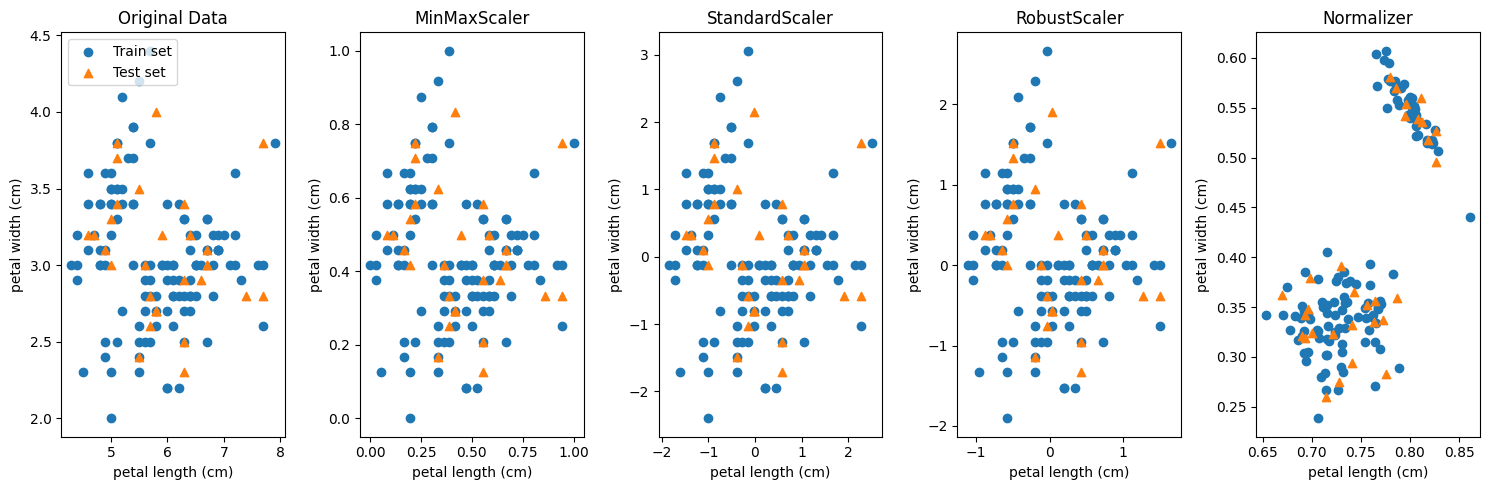

Original     : test score: 0.933   train score: 0.975
MinMaxScaler   : test score: 0.933     train score: 0.933
StandardScaler   : test score: 0.933     train score: 0.950
RobustScaler   : test score: 0.933     train score: 0.950
Normalizer   : test score: 0.867     train score: 0.858


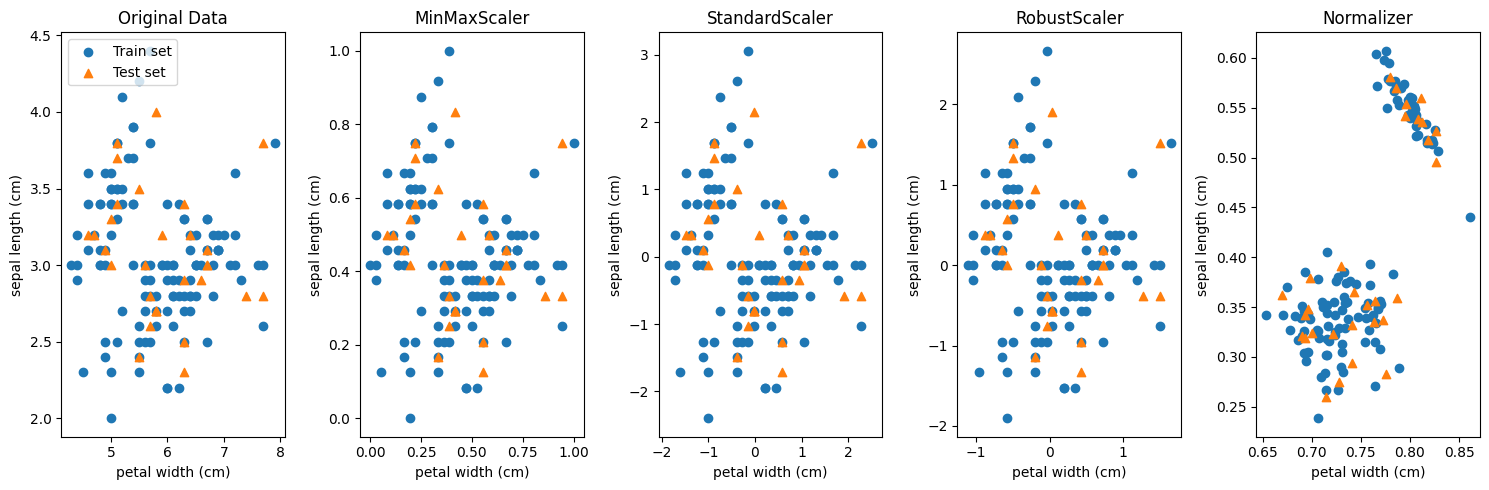

In [ ]:
# In[12]
iris.PlotScaledData()

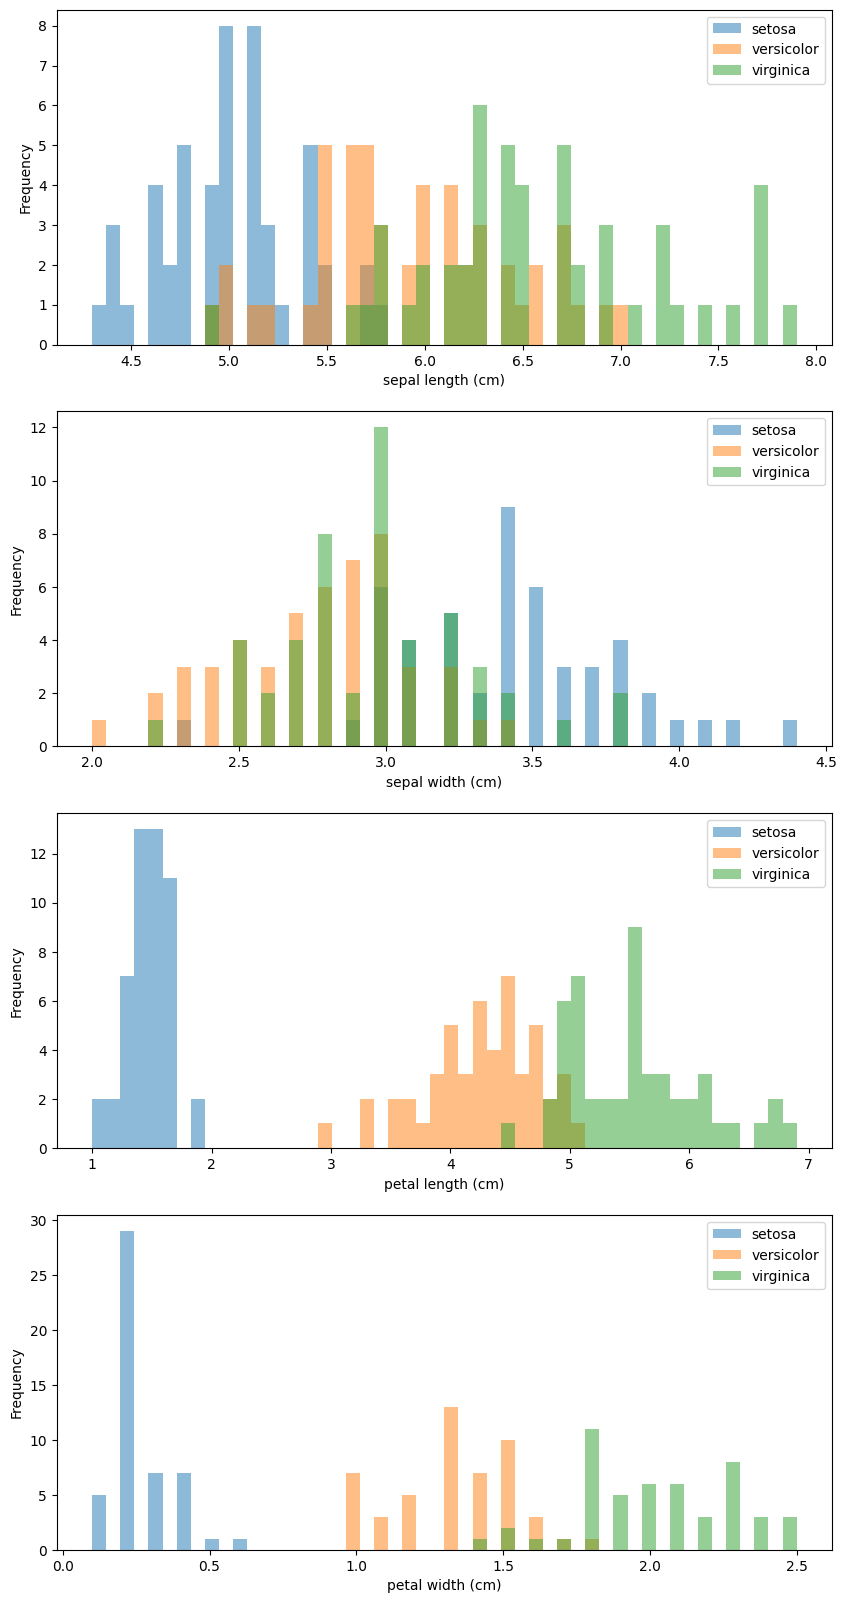

In [ ]:
# In[13]
iris = AnalyzeIris()
iris.PlotFeatureHistgram()

花弁の長さと幅が顕著に分かれていることがわかる．

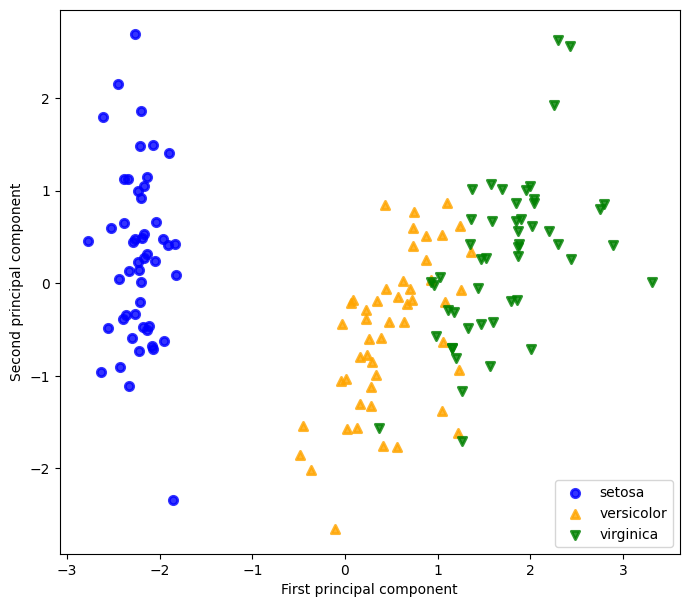

<Figure size 800x400 with 0 Axes>

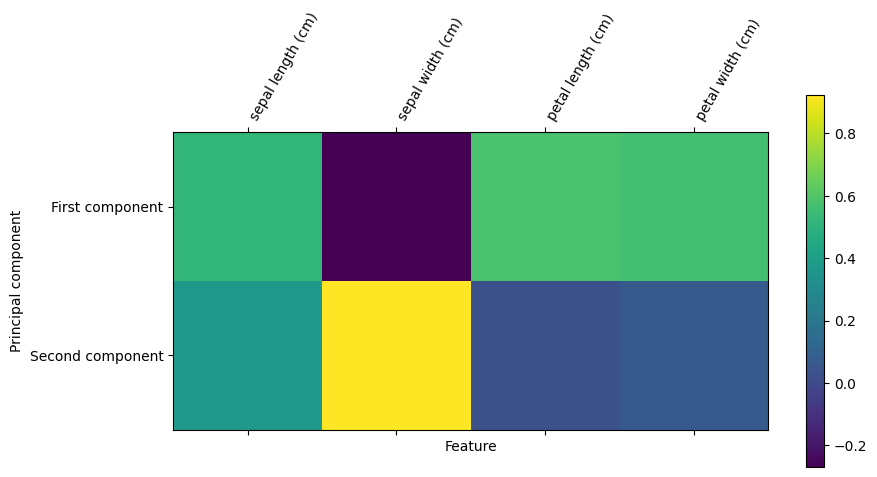

In [ ]:
# In[14]
X_scaled, df_pca, X_pca = iris.PlotPCA(n_components = 2)

In [ ]:
# In[15]
X_scaled

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


In [ ]:
# In[16]
df_pca

,0,1
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


In [ ]:
# In[17]
X_pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199]])

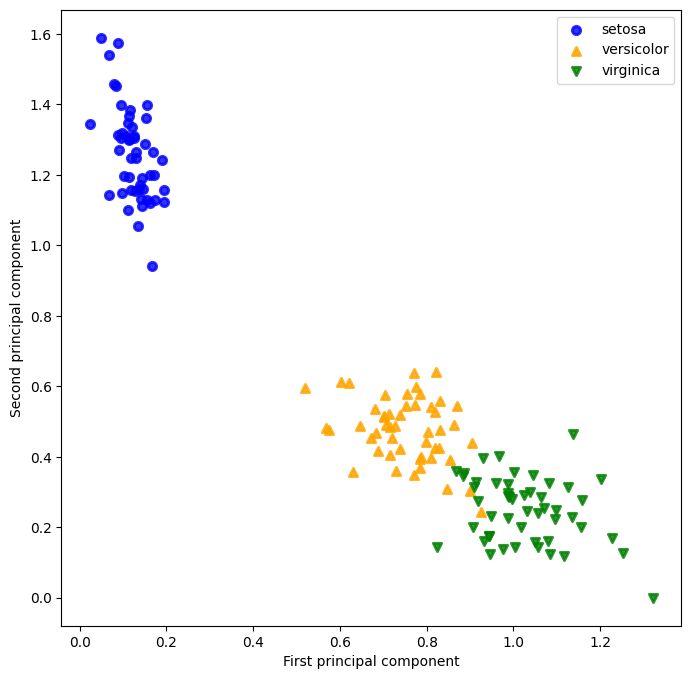

<Figure size 800x400 with 0 Axes>

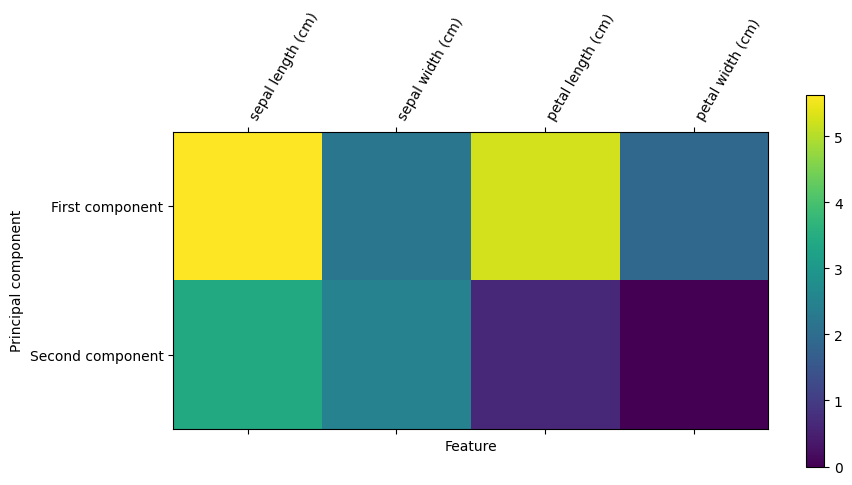

In [ ]:
# In[18]
X_scaled, df_nmf, X_nmf = iris.PlotNMF(n_components = 2)

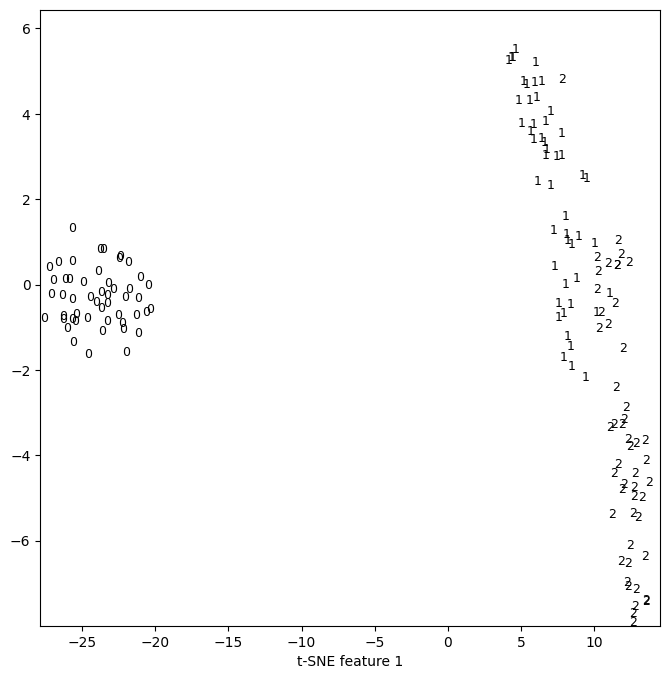

In [ ]:
# In[19]
iris.PlotTSNE()

KMeans法で予測したラベル: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


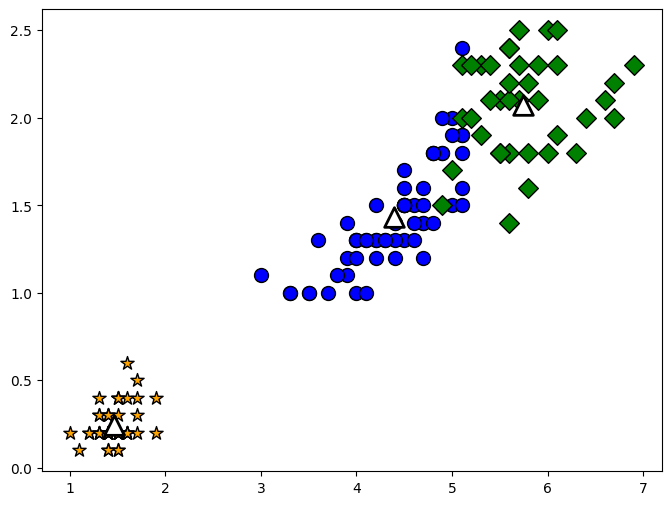

実際のラベル: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


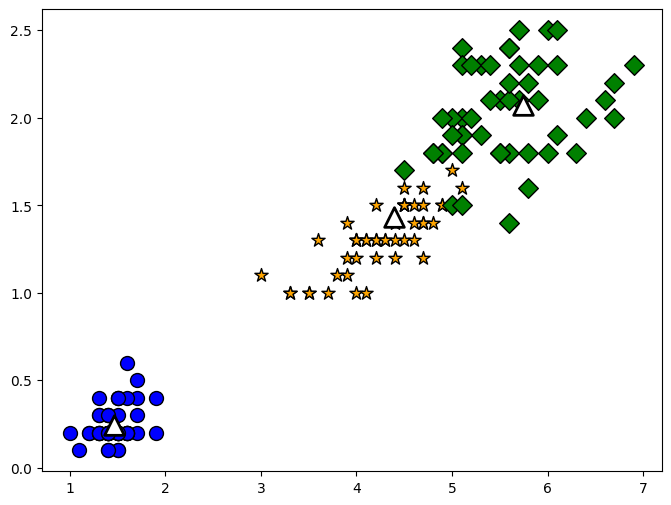

In [ ]:
# In[20]
iris.PlotKMeans()

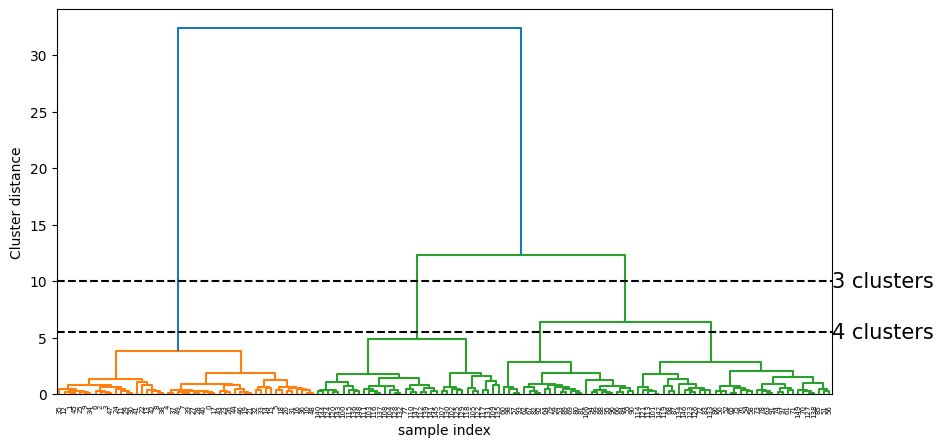

In [ ]:
# In[21]
iris.PlotDendrogram()

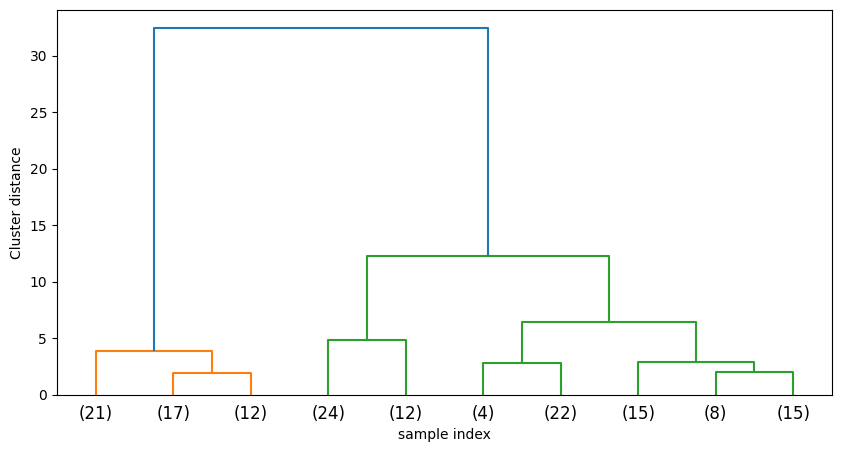

In [ ]:
# In[22]
iris.PlotDendrogram(truncate = True)

Cluster membership: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


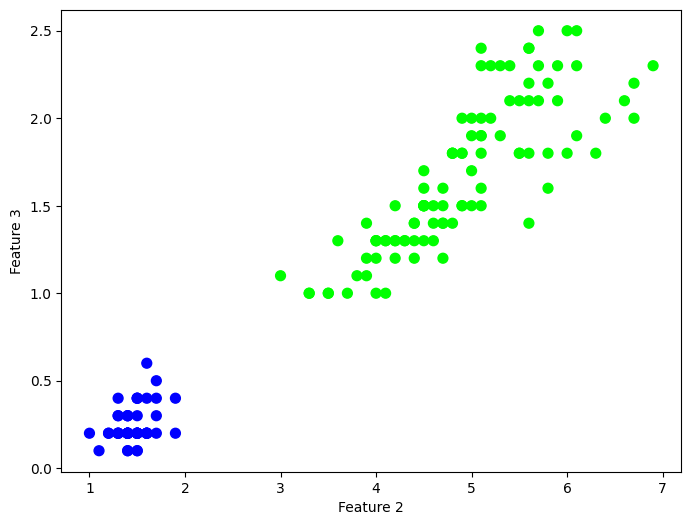

In [ ]:
# In[23]
iris.PlotDBSCAN()

Cluster membership: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


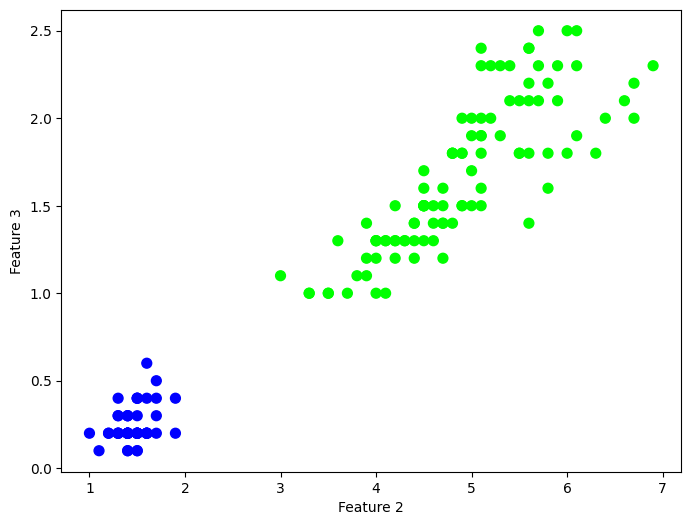

In [ ]:
# In[24]
iris.PlotDBSCAN(scaling = False, eps=1, min_samples=5)